# Road Word

In [71]:
import tensorflow as tf
import cv2 
import csv
import os
import numpy as np
print(tf.__version__)
from shutil import copyfile
import glob

1.11.0


## Arrange data

In [72]:
if not os.path.isdir('./Data/train'):
    os.makedirs('./Data/train')
if not os.path.isdir('./Data/val'):
    os.makedirs('./Data/val')
if not os.path.isdir('./Data/test'):
    os.makedirs('./Data/test')

directories = os.listdir('./Data/images/')
classes = directories
print('Number of classes: ' + str(len(directories)))
with open('./Data/data_labels.csv', mode='w') as csv_file:
    csv_writer = csv.writer(csv_file, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
    for directory in directories:
        if not os.path.isdir('./Data/train/' + directory + '/'):
            os.makedirs('./Data/train/' + directory + '/')
        if not os.path.isdir('./Data/val/' + directory + '/'):
            os.makedirs('./Data/val/' + directory + '/')
        if not os.path.isdir('./Data/test/' + directory + '/'):
            os.makedirs('./Data/test/' + directory + '/')
        for i, file in enumerate(glob.glob('./Data/images/' + directory + '/*.jpg')):
            csv_writer.writerow(['./Data/images/' + directory + '/' + file.split("/")[-1], directory])
            if (i % 4 == 0):
                copyfile(('./Data/images/' + directory + '/' + file.split("/")[-1]), './Data/val/' + directory + '/' + file.split("/")[-1])
            elif (i % 5 == 0):
                copyfile(('./Data/images/' + directory + '/' + file.split("/")[-1]), './Data/test/' + directory + '/' + file.split("/")[-1])
            else:
                copyfile(('./Data/images/' + directory + '/' + file.split("/")[-1]), './Data/train/' + directory + '/' + file.split("/")[-1])

Number of classes: 3


In [82]:
from keras import applications
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers
from keras.models import Sequential, Model 
from keras.layers import Dropout, Flatten, Dense, GlobalAveragePooling2D
from keras import backend as k 
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, TensorBoard, EarlyStopping

img_width, img_height = 64, 64
train_data_dir = "./Data/train"
validation_data_dir = "./Data/val"
nb_train_samples = 777
nb_validation_samples = 326
nb_test_samples = 193
batch_size = 32
epochs = 10

# Load in pre-trained model
model = applications.VGG16(weights = "imagenet", include_top=False, input_shape = (img_width, img_height, 3))


# Freeze the layers which you don't want to train. Here I am freezing the first 5 layers.
for layer in model.layers[:18]:
    layer.trainable = False

#Adding custom Layers 
x = model.output
x = Flatten()(x)
x = Dense(1024, activation="relu")(x)
x = Dropout(0.5)(x)
x = Dense(512, activation="relu")(x)
predictions = Dense(3, activation="softmax")(x)

# creating the final model 
model_final = Model(input = model.input, output = predictions)

# compile the model 
model_final.compile(loss = "categorical_crossentropy", optimizer = optimizers.Adam(lr=0.0001), metrics=["accuracy"])

# Initiate the train and test generators with data Augumentation 
train_datagen = ImageDataGenerator(
rescale=1. / 255,
fill_mode = "nearest",
zoom_range = 0.3,
width_shift_range = 0.3,
height_shift_range=0.3,
rotation_range=15)


test_datagen = ImageDataGenerator(rescale=1. / 255
)

# These generators ensure the images are passed to the model during training. 
# They handle opening and scaling the images
train_generator = train_datagen.flow_from_directory(
    directory=r"./Data/train/",
    target_size=(img_width, img_height),
    color_mode="rgb",
    batch_size=batch_size,
    class_mode="categorical",
    shuffle=True,
    seed=42
)

valid_generator = test_datagen.flow_from_directory(
    directory=r"./Data/val/",
    target_size=(img_width, img_height),
    color_mode="rgb",
    batch_size=batch_size,
    class_mode="categorical",
    shuffle=True,
    seed=42
)

test_generator = test_datagen.flow_from_directory(
    directory=r"./Data/test/",
    target_size=(img_width, img_height),
    color_mode="rgb",
    batch_size=batch_size,
    class_mode="categorical",
    shuffle=True,
    seed=42
)

# Save the model according to the conditions  
checkpoint = ModelCheckpoint("vgg16_1.h5", monitor='val_acc', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)
early = EarlyStopping(monitor='val_acc', min_delta=0, patience=10, verbose=1, mode='auto')

model_final.summary()



/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel/__main__.py:35: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`


Found 777 images belonging to 3 classes.
Found 326 images belonging to 3 classes.
Found 193 images belonging to 3 classes.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_12 (InputLayer)        (None, 64, 64, 3)         0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 64, 64, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 64, 64, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 32, 32, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 32, 32, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 32, 32, 128)       147584    
___________________

[0. 0. 1.]


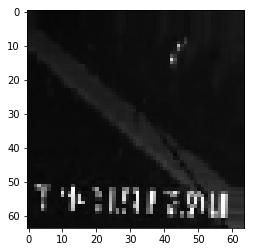

[0. 0. 1.]


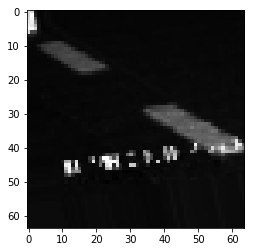

[0. 0. 1.]


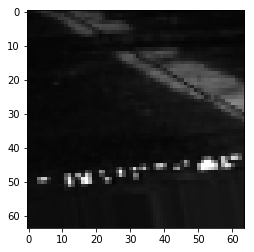

[1. 0. 0.]


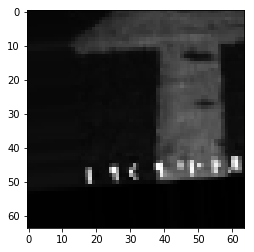

[0. 0. 1.]


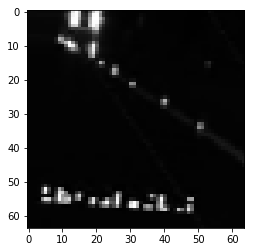

[1. 0. 0.]


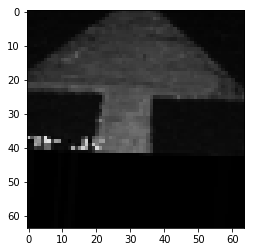

[0. 0. 1.]


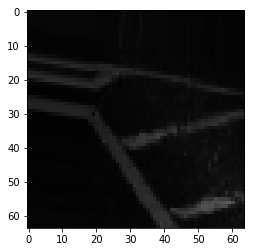

[0. 1. 0.]


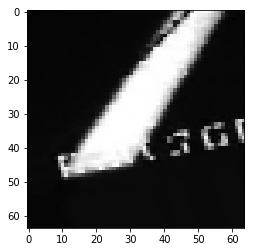

[0. 0. 1.]


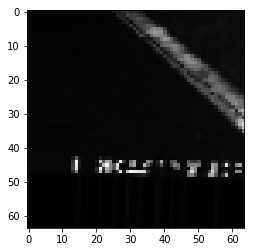

[0. 0. 1.]


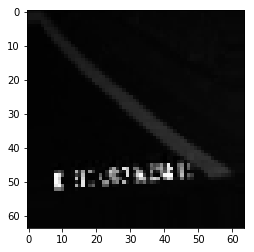

In [83]:
#Display N images
N = 10

x,y = train_generator.next()
for i in range(0,N):
    image = x[i]
    plt.imshow(image)
    print(y[i])
    plt.show()

In [84]:
# Train the model 
history = model_final.fit_generator(
train_generator,
samples_per_epoch = nb_train_samples,
epochs = epochs,
validation_data = valid_generator,
nb_val_samples = nb_validation_samples,
callbacks = [checkpoint, early])

nb_validation_samples/batch_size
score = model_final.evaluate_generator(test_generator, nb_test_samples/batch_size)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel/__main__.py:8: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel/__main__.py:8: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<keras_pre..., epochs=10, validation_data=<keras_pre..., callbacks=[<keras.ca..., steps_per_epoch=24, validation_steps=326)`


Epoch 1/10
24/24 [==============================] - 13s 534ms/step - loss: 0.9878 - acc: 0.5803 - val_loss: 0.6356 - val_acc: 0.7757

Epoch 00001: val_acc improved from -inf to 0.77568, saving model to vgg16_1.h5
Epoch 2/10
24/24 [==============================] - 11s 468ms/step - loss: 0.6396 - acc: 0.7839 - val_loss: 0.3827 - val_acc: 0.8708

Epoch 00002: val_acc improved from 0.77568 to 0.87080, saving model to vgg16_1.h5
Epoch 3/10
24/24 [==============================] - 11s 468ms/step - loss: 0.4902 - acc: 0.8320 - val_loss: 0.2906 - val_acc: 0.8714

Epoch 00003: val_acc improved from 0.87080 to 0.87136, saving model to vgg16_1.h5
Epoch 4/10
24/24 [==============================] - 11s 468ms/step - loss: 0.4453 - acc: 0.8256 - val_loss: 0.2497 - val_acc: 0.8738

Epoch 00004: val_acc improved from 0.87136 to 0.87381, saving model to vgg16_1.h5
Epoch 5/10
24/24 [==============================] - 11s 468ms/step - loss: 0.3918 - acc: 0.8456 - val_loss: 0.2075 - val_acc: 0.9082

Epoch

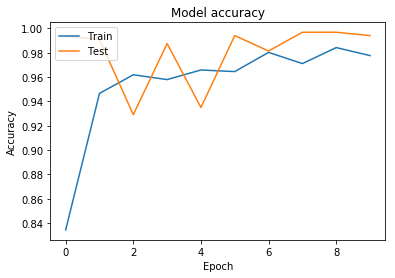

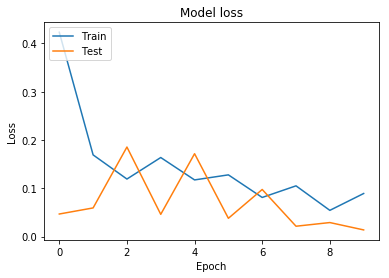

In [77]:
import matplotlib.pyplot as plt
%matplotlib inline  

# Plot training & validation accuracy values
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()